<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Walk-in-the-woods-(Tree,-Random-Forest,-XGB-&amp;-LGB)" data-toc-modified-id="Walk-in-the-woods-(Tree,-Random-Forest,-XGB-&amp;-LGB)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Walk in the woods (Tree, Random Forest, XGB &amp; LGB)</a></span></li><li><span><a href="#Fix-missing-values" data-toc-modified-id="Fix-missing-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fix missing values</a></span></li><li><span><a href="#数据分割" data-toc-modified-id="数据分割-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>数据分割</a></span></li><li><span><a href="#Define-Gini-Score-简历评价方程" data-toc-modified-id="Define-Gini-Score-简历评价方程-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define Gini Score 简历评价方程</a></span></li><li><span><a href="#单个分类树" data-toc-modified-id="单个分类树-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>单个分类树</a></span><ul class="toc-item"><li><span><a href="#Graphviz-可视化" data-toc-modified-id="Graphviz-可视化-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Graphviz 可视化</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Plot-Feature-importance" data-toc-modified-id="Plot-Feature-importance-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plot Feature importance</a></span></li></ul></li><li><span><a href="#比较单个分类树和随机森林" data-toc-modified-id="比较单个分类树和随机森林-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>比较单个分类树和随机森林</a></span><ul class="toc-item"><li><span><a href="#ROC-curve-+-AUC-简单的方式" data-toc-modified-id="ROC-curve-+-AUC-简单的方式-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>ROC curve + AUC 简单的方式</a></span></li></ul></li><li><span><a href="#XGBoost-and--Light-GBM" data-toc-modified-id="XGBoost-and--Light-GBM-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>XGBoost and  Light GBM</a></span><ul class="toc-item"><li><span><a href="#imporve-gini-score" data-toc-modified-id="imporve-gini-score-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>imporve gini score</a></span></li></ul></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Light GBM</a></span></li><li><span><a href="#Submit-Predictions" data-toc-modified-id="Submit-Predictions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Submit Predictions</a></span></li></ul></div>

# Walk in the woods (Tree, Random Forest, XGB & LGB)
The Porto Seguro's dataset is a good case study to begin with, as it is a binary classification problem (0/1), both the number of observations and features are not too large nor too small (training is quite fast) and we have to deal with missing values and imbalanced target variable.

- start by building a single decision tree, where maximum depth is chosen via cross validation (either via cross_val_score or GridSearchCV). This technique does not lead to good out-of-sample performance. 
- then try Random Forest algorithm to increase robustness, but only a small improvement was achieved. 
- Stronger Gini score is found using gradient boosting, such as XGBoost and Light GBM. 
     - While XGBoost allows us to post our highest score (0.276) on the leaderboard, Light GBM provides very similar performance on the test set with much less training time than XGBoost.


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import gc

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [20]:
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer

In [21]:
# 引入数据
rawdata_train = pd.read_csv("/Users/libolin/Downloads/Walk in the woods /train.csv", sep = ',',na_values = -1)
rawdata_test = pd.read_csv("/Users/libolin/Downloads/Walk in the woods /test.csv", sep = ',',na_values = -1)

In [22]:
rawdata_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [33]:
rawdata_train.shape

(595212, 59)

# Fix missing values
First, we visualize which features have this issue. Those with too many missing values are dropped. The others have their missing entries replaced by the mode value


In [34]:
def describe_missing_values(df):
    na_percent = {}
    N = df.shape[0]
    for column in df:
        na_percent[column] = df[column].isnull().sum() * 100 / N

    na_percent = dict(filter(lambda x: x[1] != 0, na_percent.items()))
    plt.bar(range(len(na_percent)), na_percent.values())
    plt.ylabel('Percent')
    plt.xticks(range(len(na_percent)), na_percent.keys(), rotation='vertical')
    plt.show()

Missing values for train set


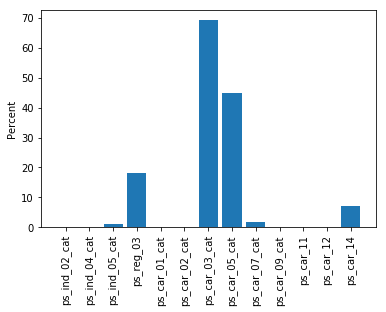

Missing values for test set


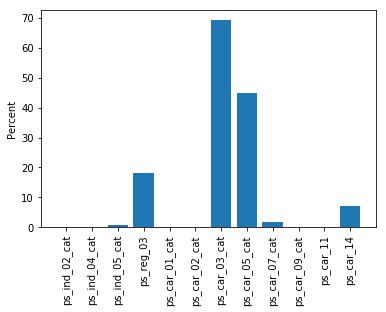

In [35]:
print("Missing values for train set")
describe_missing_values(rawdata_train)
print("Missing values for test set")
describe_missing_values(rawdata_test)

# 数据分割
- 去掉很多缺失值的columns
- 分出X和Y --- train. test

In [25]:
X = rawdata_train.drop({'target','id','ps_car_03_cat','ps_car_05_cat'},axis=1)
Y = rawdata_train['target']
X_test = rawdata_test.drop({'id','ps_car_03_cat','ps_car_05_cat'},axis=1)

In [26]:
#针对X.columns列的名字 分成三类
#1. 拥有'cat'类别
cat_cols = [col for col in X.columns if 'cat' in col]
cat_cols #拿出column名字中有‘cat’的

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [27]:
#2.拥有bin的类别
bin_cols = [col for col in X.columns if 'bin' in col]
bin_cols#拿出column名字中有‘bin’的

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

In [28]:
#3.都不在以上两种的类别
con_cols = [col for col in X.columns if col not in bin_cols + cat_cols]
# 都不存在以上两种文字特征的
con_cols

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14']

In [36]:
for col in cat_cols:
    X[col].fillna(value=X[col].mode()[0], inplace=True) #fill 众数 mode
    X_test[col].fillna(value=X_test[col].mode()[0], inplace=True)
    
for col in bin_cols: 
    X[col].fillna(value=X[col].mode()[0], inplace=True) # fill 同样mode 
    X_test[col].fillna(value=X_test[col].mode()[0], inplace=True)
    
for col in con_cols:
    X[col].fillna(value=X[col].mean(), inplace=True)  # fill mean of the column
    X_test[col].fillna(value=X_test[col].mean(), inplace=True)

# Define Gini Score 简历评价方程
**Defining Gini scoring metric**
As the submissions are evaluated using the Normalized Gini Coefficient, we create a scoring function, which will be fed into the algorithms.

In [37]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

In [38]:
def gini_normalized_score(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [39]:
score_gini = make_scorer(gini_normalized_score, greater_is_better=True, needs_threshold = True)

# 单个分类树
**Single Classification Tree**

- We choose the **tree depth** via cross validation. 
One can use either cross_val_score (it requires to manually code a loop over the depth possibilities) or GridSearchCV do all the work for you.

‘’In both cases, we see that strongest gini score is achieved with 8 as max depth.‘’

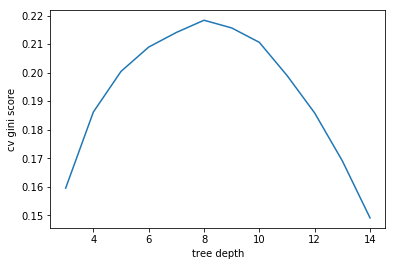

In [40]:
#（1）方法1
depth_gini = []

for i in range(3,15): #3-14的不同depth 注意python其实是最后一个15不要
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 5-fold cross validation
    scores_gini = cross_val_score(clf, X, Y, cv=5, scoring = score_gini) #将数据拟合cross validation CV=5
    depth_gini.append((i,scores_gini.mean())) #将得到的每个i对应的平均scores_gini 加入到事先准备好的【】
    
plt.plot(*zip(*depth_gini)) #用图像作出整个过程
plt.xlabel('tree depth')
plt.ylabel('cv gini score')
plt.show()
 #strongest gini score is achieved with 8 as max depth#

In [42]:
#（2）第2种方法是别出最好的depth是8
parameters = {'max_depth': np.arange(3,15)}
clf = GridSearchCV(estimator = tree.DecisionTreeClassifier(), param_grid = parameters, scoring = score_gini, cv = 5)
clf.fit(X, Y)
print("Best parameters set found on development set:")
print()
print(clf.best_estimator_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
            % (mean_score, scores.std() / 2, params))
print()

Best parameters set found on development set:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Grid scores on development set:

0.160 (+/-0.005) for {'max_depth': 3}
0.186 (+/-0.003) for {'max_depth': 4}
0.200 (+/-0.002) for {'max_depth': 5}
0.209 (+/-0.003) for {'max_depth': 6}
0.214 (+/-0.003) for {'max_depth': 7}
0.218 (+/-0.003) for {'max_depth': 8}
0.216 (+/-0.002) for {'max_depth': 9}
0.210 (+/-0.003) for {'max_depth': 10}
0.199 (+/-0.002) for {'max_depth': 11}
0.187 (+/-0.002) for {'max_depth': 12}
0.169 (+/-0.004) for {'max_depth': 13}
0.149 (+/-0.004) for {'max_depth': 14}



/Users/libolin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [41]:
parameters = {'max_depth': np.arange(3,15)}
parameters

{'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}

In [43]:
#1.先准备分类器---2，再fit XY数据-----3.最后预测---4.计算预测的概率
#1.
clf = tree.DecisionTreeClassifier(max_depth=8)
#2.
clf = clf.fit(X,Y)
#3.
Y_pred_clf = clf.predict(X)
#4.
Y_pred_proba_clf = clf.predict_proba(X)
Y_pred_clf = clf.predict(X)

In [44]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
Y_pred_clf #最终的预测 根据概率去assign 0 或者 1

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
Y_pred_clf.shape

(595212,)

In [46]:
Y_pred_proba_clf #等于0的概率和等于1的概率

array([[ 0.95132557,  0.04867443],
       [ 0.97269099,  0.02730901],
       [ 0.97782203,  0.02217797],
       ..., 
       [ 0.98395695,  0.01604305],
       [ 0.96677133,  0.03322867],
       [ 0.97556996,  0.02443004]])

In [48]:
Y_pred_proba_clf.shape

(595212, 2)

## Graphviz 可视化
clf 是之前decision tree 进行fit的分类器
对它作图

In [50]:
dot_data = tree.export_graphviz(clf,out_file=None)

In [51]:
graph = graphviz.Source(dot_data)
graph

# Random Forest
同样的方法去找 Max depth of random forest

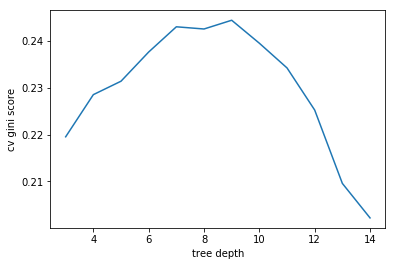

In [56]:
depth_gini = []
for i in range(3,15):
    rf = RandomForestClassifier(max_depth=i)
    # Perform 5-fold cross validation
    scores_gini = cross_val_score(rf, X, Y, cv=5, scoring = score_gini)
    depth_gini.append((i,scores_gini.mean()))
    
plt.plot(*zip(*depth_gini))
plt.xlabel('tree depth')
plt.ylabel('cv gini score')
plt.show()

In [57]:
rf = RandomForestClassifier(max_depth=9)
rf = rf.fit(X,Y)
Y_pred_rf = rf.predict(X)
Y_pred_proba_rf = rf.predict_proba(X)
Y_pred_rf = rf.predict(X)

In [58]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
Y_pred_rf 

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
Y_pred_proba_rf

array([[ 0.94617314,  0.05382686],
       [ 0.96936121,  0.03063879],
       [ 0.97712251,  0.02287749],
       ..., 
       [ 0.9803787 ,  0.0196213 ],
       [ 0.96828633,  0.03171367],
       [ 0.9721588 ,  0.0278412 ]])

In [61]:
Y_pred_proba_rf.shape

(595212, 2)

In [63]:
print(rf.feature_importances_,rf.feature_importances_.shape)

[ 0.02108222  0.00968366  0.03518851  0.00594247  0.05328181  0.01356964
  0.01461374  0.00272179  0.00388002  0.00231377  0.00396101  0.00527292
  0.00434351  0.00490205  0.02319742  0.01667616  0.03214495  0.00353517
  0.02067208  0.0386951   0.07140295  0.02632959  0.01187186  0.03056446
  0.02205526  0.00790744  0.00318619  0.0120314   0.00459663  0.01552724
  0.01069853  0.03332876  0.10315789  0.04412683  0.02691184  0.01530605
  0.01282532  0.01696456  0.01032068  0.01858636  0.01430117  0.01245747
  0.01693001  0.01110012  0.02739228  0.02462371  0.01581221  0.02067276
  0.02663849  0.00306622  0.00170547  0.00212665  0.00345279  0.00171959
  0.00462327] (55,)


In [64]:
rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1497154182, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=2039325587, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_frac

In [66]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
print(std,std.shape)

[ 0.0070667   0.00666423  0.01005907  0.00627766  0.01097534  0.01580901
  0.00934229  0.00341307  0.00347874  0.00240706  0.00291672  0.00500038
  0.00394305  0.00386694  0.00598436  0.01253815  0.01282538  0.00240488
  0.00971467  0.01921036  0.02328564  0.01046989  0.00808359  0.02080779
  0.0048659   0.00342901  0.00386088  0.00593767  0.00471879  0.00543175
  0.0057188   0.01168222  0.02553106  0.00902574  0.0102552   0.00636944
  0.00421831  0.0066142   0.00341465  0.00621436  0.00486785  0.00561558
  0.00589485  0.00403017  0.01298723  0.00518595  0.00676316  0.00954763
  0.01039934  0.00286886  0.00154098  0.00230608  0.00210714  0.00196054
  0.00383699] (55,)


## Plot Feature importance 
from random forest 

In [69]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
indices  #应该是根据重要性的排序 显示的是feature的标号 前面的重要 后面的不重要 可能

array([32, 20,  4, 33, 19,  2, 31, 16, 23, 44, 34, 48, 21, 45, 14, 24,  0,
       47, 18, 39, 37, 42, 15, 46, 29, 35,  6, 40,  5, 36, 41, 27, 22, 43,
       30, 38,  1, 25,  3, 11, 13, 54, 28, 12, 10,  8, 17, 52, 26, 49,  7,
        9, 51, 53, 50])

In [71]:
X.head(1)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2.0,5,1.0,0.0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1


In [72]:
range(X.shape[1]) # f 属于 0 到 54 

range(0, 55)

In [73]:
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
                                                     #rf.feature_importances_

Feature ranking:
1. feature 32 (0.103158)
2. feature 20 (0.071403)
3. feature 4 (0.053282)
4. feature 33 (0.044127)
5. feature 19 (0.038695)
6. feature 2 (0.035189)
7. feature 31 (0.033329)
8. feature 16 (0.032145)
9. feature 23 (0.030564)
10. feature 44 (0.027392)
11. feature 34 (0.026912)
12. feature 48 (0.026638)
13. feature 21 (0.026330)
14. feature 45 (0.024624)
15. feature 14 (0.023197)
16. feature 24 (0.022055)
17. feature 0 (0.021082)
18. feature 47 (0.020673)
19. feature 18 (0.020672)
20. feature 39 (0.018586)
21. feature 37 (0.016965)
22. feature 42 (0.016930)
23. feature 15 (0.016676)
24. feature 46 (0.015812)
25. feature 29 (0.015527)
26. feature 35 (0.015306)
27. feature 6 (0.014614)
28. feature 40 (0.014301)
29. feature 5 (0.013570)
30. feature 36 (0.012825)
31. feature 41 (0.012457)
32. feature 27 (0.012031)
33. feature 22 (0.011872)
34. feature 43 (0.011100)
35. feature 30 (0.010699)
36. feature 38 (0.010321)
37. feature 1 (0.009684)
38. feature 25 (0.007907)
39. featur

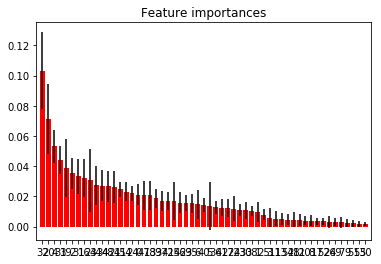

In [74]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# 比较单个分类树和随机森林
## ROC curve + AUC 简单的方式

In [75]:
# confusion matrix 
confusion_matrix(Y,Y_pred_clf)

array([[573489,     29],
       [ 21554,    140]])

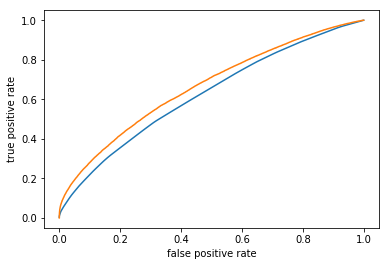

0.622547306822
0.663956570885


In [76]:
# 作图 横纵坐标 false positive rate / true positive rate
fpr_clf, tpr_clf, thresholds_clf = roc_curve(Y,Y_pred_proba_clf[:,1],pos_label = 1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y,Y_pred_proba_rf[:,1],pos_label = 1)
plt.plot(fpr_clf,tpr_clf)
plt.plot(fpr_rf,tpr_rf)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
auc_clf = np.trapz(tpr_clf,fpr_clf)
auc_rf = np.trapz(tpr_rf,fpr_rf)
print(auc_clf)
print(auc_rf)

# XGBoost and  Light GBM
## imporve gini score 


In [77]:
X.head(1)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2.0,5,1.0,0.0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1


In [79]:
#重新定义了X 这里没有去掉缺省值多的两行 ps_cat 03 和 05
X = rawdata_train.drop({'target','id'},axis=1)
X.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2.0,5,1.0,0.0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1.0,7,0.0,0.0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4.0,9,1.0,0.0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1.0,2,0.0,0.0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2.0,0,1.0,0.0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [80]:
Y = rawdata_train['target']
X_test = rawdata_test

In [91]:
# Create an XGBoost-compatible metric from Gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized_score(labels, preds)
    return [('gini', gini_score)]

In [92]:
params = {'eta': 0.2,
          'max_depth': 4,
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'silent': True}

In [93]:
features = X.columns
submission = X_test['id'].to_frame()
submission['target']=0 #多加入了target列 都是0
kfold = 3
skf = StratifiedKFold(n_splits=kfold)

In [94]:
X_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [95]:
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [96]:
#仔细看看再
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
    X_train, X_valid = X.loc[train_index], X.loc[test_index]
    Y_train, Y_valid = Y.loc[train_index], Y.loc[test_index]
    d_train = xgb.DMatrix(X_train, Y_train) 
    d_valid = xgb.DMatrix(X_valid, Y_valid) 
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, 
                        feval=gini_xgb, maximize=True, verbose_eval=100)
    submission['target'] += xgb_model.predict(xgb.DMatrix(X_test[features]), 
                        ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)


 xgb kfold: 1  of  3 : 
[0]	train-auc:0.600889	valid-auc:0.600776	train-gini:0.201141	valid-gini:0.202015
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-auc:0.687024	valid-auc:0.636534	train-gini:0.374047	valid-gini:0.273068
Stopping. Best iteration:
[65]	train-auc:0.6731	valid-auc:0.637646	train-gini:0.346199	valid-gini:0.275292

 xgb kfold: 2  of  3 : 
[0]	train-auc:0.602192	valid-auc:0.596495	train-gini:0.20358	valid-gini:0.192902
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-auc:0.685116	valid-auc:0.637802	train-gini:0.370232	valid-gini:0.275605
Stopping. Best iteration:
[74]	train-auc:0.675698	valid-auc:0.63868	train-gini:0.351396	valid-gini:0.27736

 xgb kfold: 3  of  3 : 
[0]	train-auc:0.600069	valid-auc:0.595628	train-gini:0.199974	valid-gini:0.189968
Multipl

In [98]:
gc.collect()

45

In [99]:
submission.head(2)

,id,target
0,0,0.02704
1,1,0.02950


In [100]:
parameters = {'max_depth': np.arange(3,7),
            'learning_rate': [0.2],
             'n_estimators': [20,100]}

clf = GridSearchCV(estimator = xgb.XGBClassifier(silent=True), param_grid = parameters, scoring = score_gini, cv = 3, verbose = 10, n_jobs = -1)
clf.fit(X, Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=0.2, max_depth=3, n_estimators=20 .................
[CV] learning_rate=0.2, max_depth=3, n_estimators=20 .................
[CV] learning_rate=0.2, max_depth=3, n_estimators=20 .................
[CV] learning_rate=0.2, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=20, score=0.2464851979929805, total= 1.1min
[CV] learning_rate=0.2, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=20, score=0.24763472067578687, total= 1.1min
[CV] learning_rate=0.2, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=20, score=0.2463214708229405, total= 1.2min
[CV] learning_rate=0.2, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=20, score=0.25772688908146907, total= 1.4min
[CV] learning_rate=0.2, max_depth=4, n_estimators=20 ........

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min


[CV] learning_rate=0.2, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=100, score=0.27260314280504583, total= 5.1min
[CV] learning_rate=0.2, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=20, score=0.25344805599395165, total= 1.6min
[CV] learning_rate=0.2, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=100, score=0.2776449300715454, total= 4.9min
[CV] learning_rate=0.2, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=3, n_estimators=100, score=0.2700086246123935, total= 4.9min
[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=20, score=0.26247798639410563, total= 1.5min


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.9min


[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=20, score=0.2604890193363969, total= 1.6min
[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=20, score=0.2569043594494713, total= 1.9min
[CV] learning_rate=0.2, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=100, score=0.2729931343981675, total= 6.3min
[CV] learning_rate=0.2, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=100, score=0.2754161999739574, total= 6.1min
[CV] learning_rate=0.2, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=100, score=0.26889605427231056, total= 6.2min
[CV] learning_rate=0.2, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=20, score=0.2620230719069309, total=  34.6s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.1min


[CV] learning_rate=0.2, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=20, score=0.26106753279061523, total= 1.8min
[CV] learning_rate=0.2, max_depth=6, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=100, score=0.26643798927385837, total= 5.8min
[CV] learning_rate=0.2, max_depth=6, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=100, score=0.2669899758376393, total= 5.7min


[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 17.6min remaining:  3.5min


[CV] learning_rate=0.2, max_depth=6, n_estimators=100 ................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=100, score=0.2635011785008415, total= 5.9min
[CV]  learning_rate=0.2, max_depth=6, n_estimators=100, score=0.25823308368609654, total= 7.6min
[CV]  learning_rate=0.2, max_depth=6, n_estimators=100, score=0.26062555567035894, total= 7.4min
[CV]  learning_rate=0.2, max_depth=6, n_estimators=100, score=0.25395038073063336, total= 7.4min


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 25.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([3, 4, 5, 6]), 'learning_rate': [0.2], 'n_estimators': [20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(gini_normalized_score, needs_threshold=True),
       verbose=10)

# Light GBM

In [101]:
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized_score(labels, preds)
    return [('gini', gini_score, True)]

In [102]:
params = {'learning_rate' : 0.2, 'max_depth':6, 'max_bin':10,  'objective': 'binary', 
        'metric': 'auc'}

features = X.columns
submission = X_test['id'].to_frame()
submission['target']=0

kfold = 5
skf = StratifiedKFold(n_splits=kfold)
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(' lgb kfold: {}  of  {} : '.format(i+1, kfold))
    X_train, X_valid = X.loc[train_index], X.loc[test_index]
    Y_train, Y_valid = Y.loc[train_index], Y.loc[test_index]
    lgb_model = lgb.train(params, lgb.Dataset(X_train, label=Y_train), 400, 
                  lgb.Dataset(X_valid, label=Y_valid), verbose_eval=100, 
                  feval=gini_lgb, early_stopping_rounds=50)
    submission['target'] += lgb_model.predict(X_test[features], 
                        num_iteration=lgb_model.best_iteration) / (kfold)
gc.collect()
submission.head(2)

 lgb kfold: 1  of  5 : 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.632335	valid_0's gini: 0.26467
Early stopping, best iteration is:
[54]	valid_0's auc: 0.637125	valid_0's gini: 0.27425
 lgb kfold: 2  of  5 : 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	valid_0's auc: 0.639291	valid_0's gini: 0.278581
 lgb kfold: 3  of  5 : 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	valid_0's auc: 0.639022	valid_0's gini: 0.278045
 lgb kfold: 4  of  5 : 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[48]	valid_0's auc: 0.642211	valid_0's gini: 0.284422
 lgb kfold: 5  of  5 : 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	valid_0's auc: 0.635118	valid_0's gini: 0.270236


,id,target
0,0,0.026588
1,1,0.028736


# Submit Predictions 

In [ ]:
submission.to_csv("./submission.csv", index=False, float_format='%.5f')